<a href="https://colab.research.google.com/github/Sidharth-Darwin/PyTorch_Programs/blob/main/denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [4]:
np.random.seed(42)
torch.manual_seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
class NoisyMNIST(Dataset):
    def __init__(self, img_data_path, train=True, noise_factor=0.2):
        super(NoisyMNIST, self).__init__()
        self.img_data_path = img_data_path
        self.img_transforms = ToTensor()
        self.noise_factor = noise_factor
        self.train = train
        if self.train:
            self.mnist_df = MNIST(self.img_data_path, transform=self.img_transforms, train=True, download=True)
        else:
            self.mnist_df = MNIST(self.img_data_path, transform=self.img_transforms, train=False, download=True)
        self.len = len(self.mnist_df)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        clean_img, _ = self.mnist_df[index]
        noisy_img = clean_img + self.noise_factor * torch.randn_like(clean_img)
        noisy_img = torch.clip(noisy_img, 0.0, 1.0)

        return (noisy_img, clean_img)

In [7]:
train_ds = NoisyMNIST("/content/data")
test_ds = NoisyMNIST("/content/data", train=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 58920906.67it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1901718.95it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 14559679.41it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4641941.71it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [8]:
len(train_ds), len(test_ds)

(60000, 10000)

In [9]:
def compare_noisy_clean_output(noisy, clean, output=None):
    noisy = noisy.detach().cpu().squeeze()
    clean = clean.detach().cpu().squeeze()
    if output is None:
        fig, axs = plt.subplots(1, 2)
        fig.suptitle("Noisy vs Clean")
        axs[0].imshow(noisy, cmap="binary")
        axs[0].set_title("Noisy")
        axs[0].axis("off")
        axs[1].imshow(clean, cmap="binary")
        axs[1].set_title("Clean")
        axs[1].axis("off")
    else:
        output = output.detach().cpu().squeeze()
        fig, axs = plt.subplots(1, 3)
        fig.suptitle("Noisy vs Clean vs Output")
        axs[0].imshow(noisy, cmap="binary")
        axs[0].set_title("Noisy")
        axs[0].axis("off")
        axs[1].imshow(clean, cmap="binary")
        axs[1].set_title("Clean")
        axs[1].axis("off")
        axs[2].imshow(output, cmap="binary")
        axs[2].set_title("Output")
        axs[2].axis("off")
    plt.tight_layout()
    plt.show()

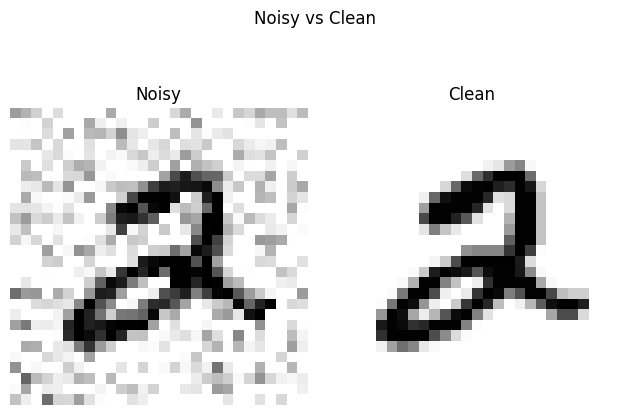

In [10]:
noisy, clean = train_ds[5]
compare_noisy_clean_output(noisy, clean)

In [11]:
noisy.shape, clean.shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

In [12]:
batch_size = 32

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
len(train_dl), len(test_dl)

(1875, 313)

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

    def forward(self, inp):
        return self.encoder(inp)

encoder = Encoder()
x = torch.rand(1, 1, 28, 28)
print("Encoder input shape:", x.shape)
total_n_params = 0
for layer in encoder.encoder:
    x = layer(x)
    n_params_per_layer = sum([n.numel() for n in layer.parameters()])
    total_n_params += n_params_per_layer
    print(f"{layer._get_name():<15}: {str(x.shape):<30}: {n_params_per_layer:<10}")
print(f"Total number of parameters: {total_n_params}")
print("Encoder output shape:", encoder(torch.rand(1, 1, 28, 28)).shape)

Encoder input shape: torch.Size([1, 1, 28, 28])
Conv2d         : torch.Size([1, 64, 28, 28])   : 640       
BatchNorm2d    : torch.Size([1, 64, 28, 28])   : 128       
ReLU           : torch.Size([1, 64, 28, 28])   : 0         
MaxPool2d      : torch.Size([1, 64, 14, 14])   : 0         
Conv2d         : torch.Size([1, 32, 14, 14])   : 18464     
BatchNorm2d    : torch.Size([1, 32, 14, 14])   : 64        
ReLU           : torch.Size([1, 32, 14, 14])   : 0         
MaxPool2d      : torch.Size([1, 32, 7, 7])     : 0         
Conv2d         : torch.Size([1, 16, 7, 7])     : 4624      
BatchNorm2d    : torch.Size([1, 16, 7, 7])     : 32        
ReLU           : torch.Size([1, 16, 7, 7])     : 0         
Total number of parameters: 23952
Encoder output shape: torch.Size([1, 16, 7, 7])


In [15]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, inp):
        return self.decoder(inp)

decoder = Decoder()
total_n_params = 0
print("Decoder input shape:", x.shape)
for layer in decoder.decoder:
    x = layer(x)
    n_params_per_layer= sum([n.numel() for n in layer.parameters()])
    total_n_params += n_params_per_layer
    print(f"{layer._get_name():<15}: {x.shape} : {n_params_per_layer:<10}")
print(f"Total number of parameters: {total_n_params}")
print()

Decoder input shape: torch.Size([1, 16, 7, 7])
Conv2d         : torch.Size([1, 32, 7, 7]) : 4640      
BatchNorm2d    : torch.Size([1, 32, 7, 7]) : 64        
ReLU           : torch.Size([1, 32, 7, 7]) : 0         
Upsample       : torch.Size([1, 32, 14, 14]) : 0         
Conv2d         : torch.Size([1, 64, 14, 14]) : 18496     
BatchNorm2d    : torch.Size([1, 64, 14, 14]) : 128       
ReLU           : torch.Size([1, 64, 14, 14]) : 0         
Upsample       : torch.Size([1, 64, 28, 28]) : 0         
Conv2d         : torch.Size([1, 1, 28, 28]) : 577       
Sigmoid        : torch.Size([1, 1, 28, 28]) : 0         
Total number of parameters: 23905



In [16]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, inp):
        x = self.encoder(inp)
        x = self.decoder(x)
        return x

model = AutoEncoder()
print("Autoencoder Output shape:", model(torch.rand(1, 1, 28, 28)).shape)
print(sum([x.numel() for x in model.parameters()]))

Autoencoder Output shape: torch.Size([1, 1, 28, 28])
47857


In [17]:
class EarlyStopperMinDelta:
    def __init__(self, patience=1, min_delta=0, after_epoch=0):
        self.patience = patience
        self.min_delta = min_delta
        self.after_epoch = after_epoch
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.saved_state_dict = None

    def early_stop(self, validation_loss, state_dict, epoch=float('inf')):
        if epoch > self.after_epoch and validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.saved_state_dict = state_dict
        elif epoch > self.after_epoch and validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopperMinDelta(patience=5, min_delta=0.0001, after_epoch=10)

In [18]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [19]:
n_epochs = 500
for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}")

    print("Training...")
    avg_train_loss = 0.0
    model.train()
    for noisy, clean in train_dl:
        noisy = noisy.to(device)
        clean = clean.to(device)
        optimizer.zero_grad()
        out = model(noisy)
        loss = criterion(out, clean)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(train_dl)
    print("Avg train loss:", avg_train_loss)

    print("Validating...")
    avg_val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for noisy, clean in test_dl:
            noisy = noisy.to(device)
            clean = clean.to(device)
            out = model(noisy)
            loss = criterion(out, clean)
            avg_val_loss += loss.item()
    avg_val_loss /= len(test_dl)
    print("Avg val loss:", avg_val_loss)

    if early_stopper.early_stop(avg_val_loss, model.state_dict(), epoch):
        print(f"Early stopped at epoch {epoch+1}")
        model.load_state_dict(early_stopper.saved_state_dict)
        break
    print("-" * 80)

EPOCH 1
Training...
Avg train loss: 0.014396872648348411
Validating...
Avg val loss: 0.005732215017068405
--------------------------------------------------------------------------------
EPOCH 2
Training...
Avg train loss: 0.005328846991683046
Validating...
Avg val loss: 0.00457722044805773
--------------------------------------------------------------------------------
EPOCH 3
Training...
Avg train loss: 0.004587098725140095
Validating...
Avg val loss: 0.004338772861084666
--------------------------------------------------------------------------------
EPOCH 4
Training...
Avg train loss: 0.004239713711291552
Validating...
Avg val loss: 0.0038917934865699694
--------------------------------------------------------------------------------
EPOCH 5
Training...
Avg train loss: 0.003990278578425447
Validating...
Avg val loss: 0.003709692749739312
--------------------------------------------------------------------------------
EPOCH 6
Training...
Avg train loss: 0.0038268198408186434
Validat

KeyboardInterrupt: 

In [20]:
torch.save(model.state_dict(), "model_sd.pth")

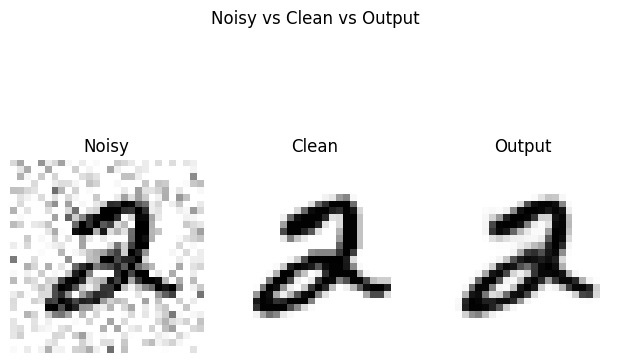

In [21]:
model.eval()
noisy, clean = train_ds[5]
output = model(noisy.unsqueeze(0).to(device))
compare_noisy_clean_output(noisy, clean, output)